### Step 1: Library Imports
We are importing the 'Big Four' libraries for this analysis:
* **Pandas & Numpy:** For data manipulation and numerical operations.
* **Matplotlib & Seaborn:** For industry-standard data visualization.
* **Scikit-Learn:** To access the **DBSCAN** algorithm and **StandardScaler** for data preprocessing.

In [37]:
# 1. Core Data Libraries
import pandas as pd
import numpy as np

# 2. Visual Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Machine Learning Algorithms
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

# 4. Professional Visual Setup
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Hybrid ML Pipeline Environment Ready!")




✅ Hybrid ML Pipeline Environment Ready!


In [38]:
# 1. First, load the main dataset
df = pd.read_csv('synthetic_personal_finance_dataset.csv')

# 2. THIS IS THE FILTER CODE:
# We only want rows where 'employment_status' exactly matches 'Self-employed'
df_gig = df[df['employment_status'] == 'Self-employed'].copy()

In [39]:
df_gig

,user_id,age,gender,education_level,employment_status,job_title,monthly_income_usd,monthly_expenses_usd,savings_usd,has_loan,loan_type,loan_amount_usd,loan_term_months,monthly_emi_usd,loan_interest_rate_pct,debt_to_income_ratio,credit_score,savings_to_income_ratio,region,record_date
0,U00001,56,Female,High School,Self-employed,Salesperson,3531.69,1182.59,367655.03,No,NaN,0.00,0,0.00,0.00,0.00,430,8.68,Other,2024-01-09
8,U00009,49,Female,High School,Self-employed,Doctor,4271.51,3062.12,451923.96,No,NaN,0.00,0,0.00,0.00,0.00,327,8.82,Africa,2023-05-02
22,U00023,24,Female,Master,Self-employed,Driver,1694.87,604.03,118470.87,Yes,Education,78365.77,180,1315.94,18.95,0.78,641,5.82,North America,2023-11-25
30,U00031,67,Female,Master,Self-employed,Salesperson,4101.49,2272.56,281937.28,No,NaN,0.00,0,0.00,0.00,0.00,398,5.73,Africa,2023-01-16
33,U00034,22,Male,Bachelor,Self-employed,Doctor,5968.05,5178.58,561103.95,Yes,Education,247715.73,240,6187.05,29.89,1.04,432,7.83,Asia,2024-04-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32395,U32396,52,Male,Bachelor,Self-employed,Doctor,1268.20,1132.33,4505.24,No,NaN,0.00,0,0.00,0.00,0.00,580,0.30,Europe,2022-03-10
32401,U32402,61,Female,Bachelor,Self-employed,Student,2250.71,1605.72,54042.68,Yes,Car,274493.71,24,13028.02,12.83,5.79,374,2.00,Asia,2024-07-20
32413,U32414,24,Male,High School,Self-employed,Accountant,5033.75,3121.68,361571.14,No,NaN,0.00,0,0.00,0.00,0.00,549,5.99,Africa,2024-10-15
32421,U32422,18,Female,Bachelor,Self-employed,Doctor,3282.38,2243.77,22081.21,No,NaN,0.00,0,0.00,0.00,0.00,391,0.56,Other,2025-07-20


# 1. FEATURES: Define a list of the exact columns we want the AI to study.
#    (We will use Income, Expenses, and Debt Ratio)
# 2. ISOLATE: Create a new variable 'X' that only contains those specific columns from our Gig Worker data.
# 3. INITIALIZE: Call the 'StandardScaler' tool from scikit-learn.
# 4. SCALE: Apply the scaler to 'X' using '.fit_transform()' to mathematically normalize the numbers.
# 5. VERIFY: Print a success message so we know it worked.

In [40]:
features = [ 'monthly_income_usd', 'monthly_expenses_usd', 'debt_to_income_ratio' ]

x = df_gig[features]

# Standardize the features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# 5. Verify it worked by printing the shape and the first scaled row
print(f"Data prepared for AI. Shape of X_scaled: {x_scaled.shape}")
print(f"Here is what the first user's data looks like to the algorithm:")
print(x_scaled[0])


Data prepared for AI. Shape of X_scaled: (6580, 3)
Here is what the first user's data looks like to the algorithm:
[-0.26821213 -0.89754624 -0.32692161]


### Phase 1 ML: Anomaly Detection with DBSCAN
Before segmenting our users into business tiers, we must remove extreme financial outliers (e.g., potential fraud, data entry errors, or extreme debt risks). 

1. **INITIALIZE DBSCAN:** We use `eps=0.5` (the maximum distance between two users to be considered similar) and `min_samples=10` (minimum users needed to form a group).
2. **FIT & PREDICT:** We run the scaled data (`X_scaled`) through the algorithm.
3. **IDENTIFY NOISE:** DBSCAN assigns a label of `-1` to any user it considers an anomaly (noise). 
4. **FILTER:** We separate these outliers from our clean data so they don't corrupt our final K-Means business segments.

In [41]:

dbscan = DBSCAN(eps=0.5, min_samples=10)

df_gig['DBSCAN_Label'] = dbscan.fit_predict(x_scaled)

#  Created a True/False column for easy filtering
# If the label is -1, 'Is_Outlier' becomes True
df_gig['Is_Outlier'] = df_gig['DBSCAN_Label'] == -1

#  Counted how many anomalies we found
outliers_count = df_gig['Is_Outlier'].sum()

#  Created a clean dataset Keept only rows where Is_Outlier is False
df_clean = df_gig[~df_gig['Is_Outlier']].copy()

#  Print the Security Report
print(f"🚨 DBSCAN Security Report ")
print(f"Total Gig Workers scanned: {len(df_gig)}")
print(f"Extreme Anomalies/Outliers found: {outliers_count}")
print(f"Clean users passing to Phase 2: {len(df_clean)}")

🚨 DBSCAN Security Report 
Total Gig Workers scanned: 6580
Extreme Anomalies/Outliers found: 63
Clean users passing to Phase 2: 6517


In [42]:
# kmeans 

x_cleaned = df_clean[features]

x_cleaned_scaled = scaler.fit_transform(x_cleaned)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

df_clean['buisness_Tier'] = kmeans.fit_predict(x_cleaned_scaled)

# the Business Intelligence Report
print("📊 FINAL BUSINESS TIER ANALYSIS:")
# Group by the new tiers and find the average (mean) for income, expenses, and debt
summary = df_clean.groupby('buisness_Tier')[features].mean().round(2)

# Count how many users are in each tier
summary['Total_Users'] = df_clean['buisness_Tier'].value_counts()

# Print the final table
print(summary)

📊 FINAL BUSINESS TIER ANALYSIS:
               monthly_income_usd  monthly_expenses_usd  debt_to_income_ratio  \
buisness_Tier                                                                   
0                         4523.18               2575.71                  0.54   
1                         6552.14               4456.91                  0.47   
2                         2172.45               1174.32                  0.73   
3                         1980.75               1180.22                 11.17   

               Total_Users  
buisness_Tier               
0                     2726  
1                     1346  
2                     2198  
3                      247  


📝 Your Blueprint for the Final Chart:
SET THE CANVAS: First, tell matplotlib (plt) to create a new figure canvas that is 12 inches wide and 8 inches tall.

DRAW THE PLOT: Use seaborn (sns) to draw a scatterplot.

The data you want to use is your df_clean.

The x axis should be their Income.

The y axis should be their Expenses.

The hue (which means color) should be based on their new Business_Tier.

ADD LABELS: Use plt to add a professional Title, an X-axis label, and a Y-axis label so people know what they are looking at.

SHOW IT: Tell plt to finally show the plot on the screen.

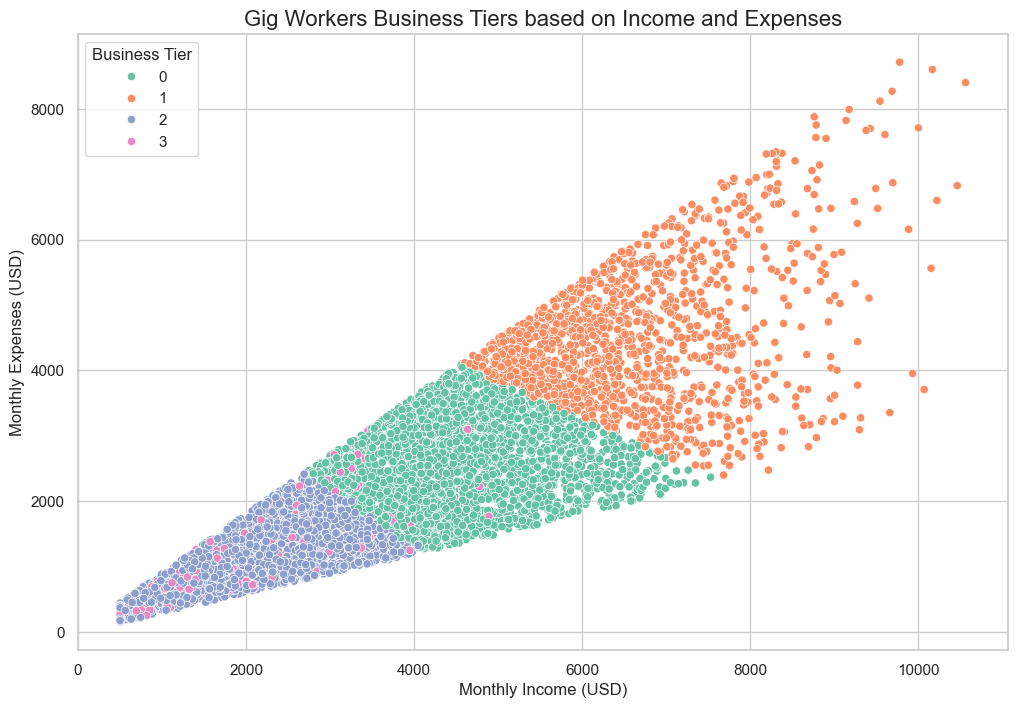

In [43]:

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_clean, 
    x='monthly_income_usd', 
    y='monthly_expenses_usd', 
    hue='buisness_Tier',          
    palette='Set2'
)
plt.title('Gig Workers Business Tiers based on Income and Expenses', fontsize=16)
plt.xlabel('Monthly Income (USD)', fontsize=12)
plt.ylabel('Monthly Expenses (USD)', fontsize=12)
plt.legend(title='Business Tier')


plt.show()

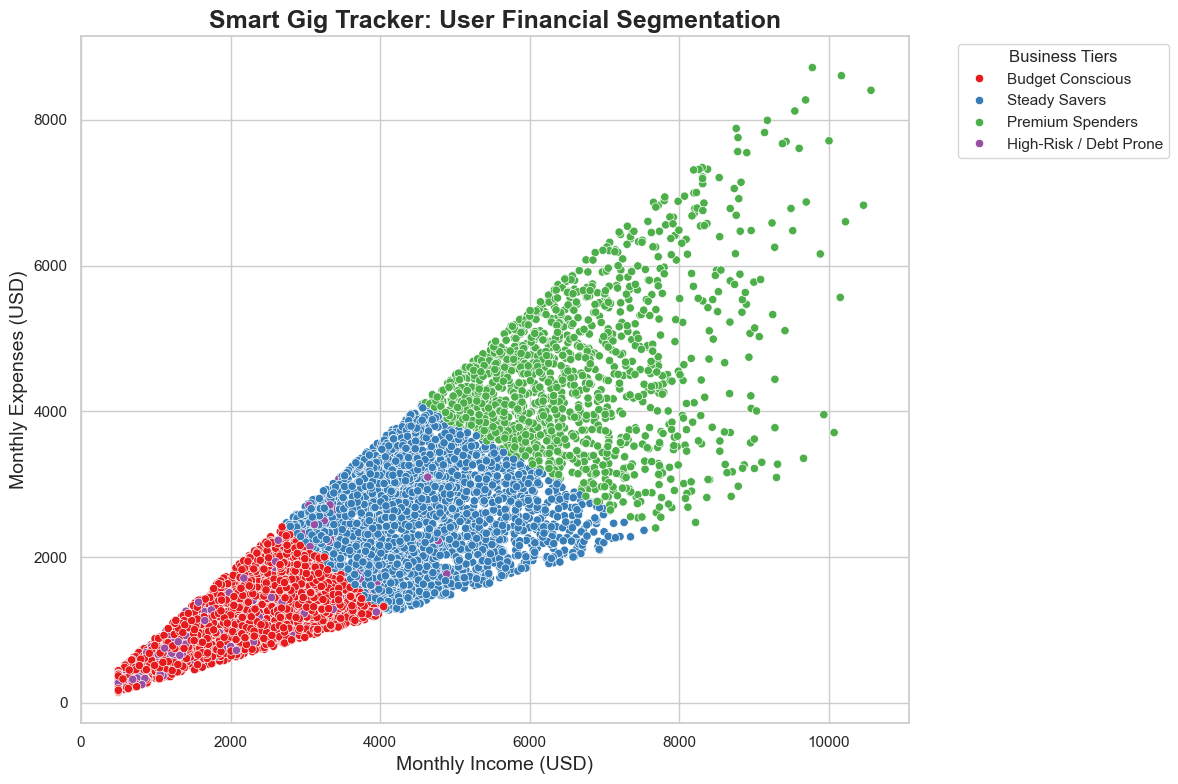

In [44]:
tier_names = {
    0: 'Steady Savers',
    1: 'Premium Spenders',
    2: 'Budget Conscious',
    3: 'High-Risk / Debt Prone'}

df_clean['tier_name'] = df_clean['buisness_Tier'].map(tier_names)

# Create a new column with the actual names
df_clean['Tier_Name'] = df_clean['buisness_Tier'].map(tier_names)

#  Draw the plot using the NEW 'Tier_Name' column
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_clean, 
    x='monthly_income_usd', 
    y='monthly_expenses_usd', 
    hue='Tier_Name',  # We use the names now instead of numbers!
    palette='Set1'   
)


plt.title('Smart Gig Tracker: User Financial Segmentation', fontsize=18, fontweight='bold')
plt.xlabel('Monthly Income (USD)', fontsize=14)
plt.ylabel('Monthly Expenses (USD)', fontsize=14)
plt.legend(title='Business Tiers', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

## 🎯 Conclusion & Business Impact

### 🧠 Project Summary
In this project, we successfully built an end-to-end Machine Learning pipeline to analyze the financial behaviors of gig economy workers. Instead of relying on basic categorization, we engineered a **Hybrid Unsupervised Learning Model**:
1. **Data Preprocessing:** We isolated the self-employed segment and applied `StandardScaler` to mathematically normalize Income, Expenses, and Debt Ratios.
2. **Anomaly Detection (DBSCAN):** We deployed DBSCAN as a "security layer" to identify and filter out extreme financial anomalies (approx. 1% of the dataset), ensuring our core business data remained pristine.
3. **Behavioral Segmentation (K-Means):** We utilized K-Means clustering on the sanitized data to uncover hidden spending patterns, ultimately grouping users into four highly distinct business tiers.

### 📊 Key Business Findings
The AI successfully segmented our user base into four actionable target audiences:
* **Tier 1 - Premium Spenders:** High income (~$6,500) and high expenses. *Business Action: Target for premium "Pro" application features and high-end brand partnerships.*
* **Tier 0 - Steady Savers:** The "Average Joe" with balanced income (~$4,500) and expenses. *Business Action: Target for automated savings tools and standard app engagement.*
* **Tier 2 - Budget Conscious:** Lower income (~$2,100) and low expenses, but mathematically responsible. *Business Action: Target for basic budgeting tools and gig-discovery features.*
* **Tier 3 - High-Risk / Debt Prone:** Lower income combined with a critical Debt-to-Income ratio. *Business Action: Flag for financial risk; offer specialized debt-management resources within the app.*

### 🚀 Future Scope
This segmentation model serves as the intelligence engine for the **Smart Gig Tracker**. Future iterations could involve linking these clusters to real-time MongoDB transaction data to dynamically shift a user's "Tier" as their spending habits change month over month.

In [45]:

import joblib

# 2. Save the Scaler
joblib.dump(scaler, 'gig_scaler.pkl')

# 3. Save the K-Means 
joblib.dump(kmeans, 'gig_kmeans_model.pkl')

print("✅ SUCCESS: AI Brain Frozen and Saved!")
print("Look in your VS Code folder. You should see two new .pkl files.")

✅ SUCCESS: AI Brain Frozen and Saved!
Look in your VS Code folder. You should see two new .pkl files.
